<a href="https://colab.research.google.com/github/jtorresle/AlgorithmsUN2024II/blob/main/Talleres/2025-06-06_taller_bci_simulado_control_visual/bci_simulado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sección 1: Instalación e imports
!pip install numpy pandas matplotlib scipy ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from ucimlrepo import fetch_ucirepo

# Sección 2: Cargar dataset EEG Eye State desde UCI
eeg_eye_state = fetch_ucirepo(id=264)
X = eeg_eye_state.data.features        # DataFrame 14980×14
y = eeg_eye_state.data.targets         # Serie 14980×1 (0=open, 1=closed)

# Para simplificar, seleccionamos un canal EEG (p.ej. AF3, índice 0)
signal = X.iloc[:, 0].values.astype(float)

# Definimos un muestreo típico de 128 Hz (según especificación del dataset)
fs = 128.0
N = len(signal)
time = np.arange(N) / fs               # eje de tiempo en segundos


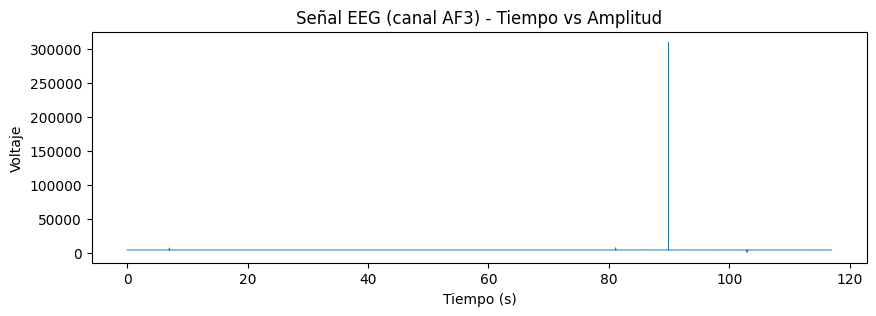

In [3]:
# Sección 3: Visualizar la señal en el dominio del tiempo
plt.figure(figsize=(10, 3))
plt.plot(time, signal, color='C0', linewidth=0.7)
plt.title('Señal EEG (canal AF3) - Tiempo vs Amplitud')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje')
plt.show()

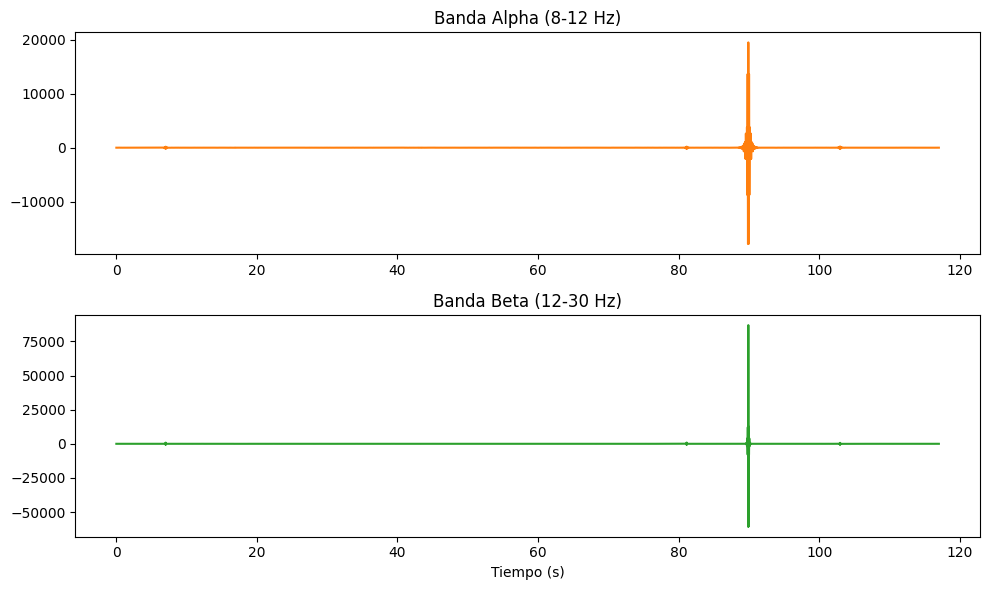

In [4]:
# Sección 4: Definir y aplicar filtros pasa banda (Alpha y Beta)
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

eeg_alpha = bandpass_filter(signal, fs, 8, 12)
eeg_beta  = bandpass_filter(signal, fs, 12, 30)

# Visualizar las bandas filtradas
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(time, eeg_alpha, color='C1')
plt.title('Banda Alpha (8-12 Hz)')
plt.subplot(2,1,2)
plt.plot(time, eeg_beta, color='C2')
plt.title('Banda Beta (12-30 Hz)')
plt.xlabel('Tiempo (s)')
plt.tight_layout()
plt.show()

In [5]:
# Sección 5: Calcular potencia en banda Alpha y definir umbral de "atención"
def bandpower(data, fs):
    f, Pxx = welch(data, fs=fs, nperseg=512)
    return np.trapz(Pxx, f)

power_alpha = bandpower(eeg_alpha, fs)
threshold = np.percentile(eeg_alpha**2, 75)  # percentil 75 de potencia instantánea

<ipython-input-5-94e976298b58>:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx, f)


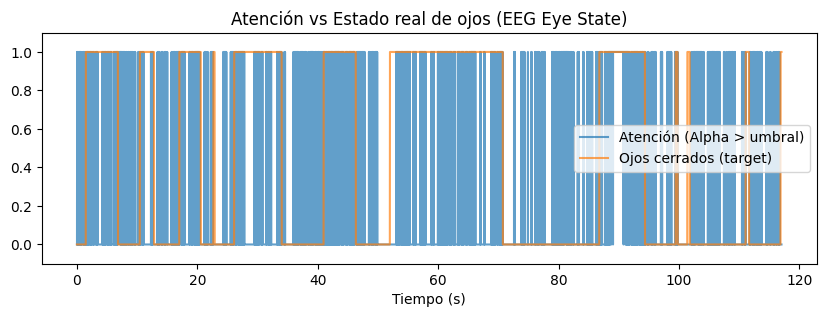

In [6]:
# Sección 6: Evaluar condición de atención
attention = (eeg_alpha**2 > threshold).astype(int)

# Visualizar "nivel de atención" vs estado real de ojos (y)
plt.figure(figsize=(10,3))
plt.plot(time, attention, label='Atención (Alpha > umbral)', alpha=0.7)
plt.plot(time, y.values, label='Ojos cerrados (target)', alpha=0.7)
plt.ylim(-0.1, 1.1)
plt.title('Atención vs Estado real de ojos (EEG Eye State)')
plt.xlabel('Tiempo (s)')
plt.legend()
plt.show()

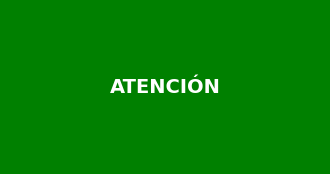

In [11]:
idx = np.argmax(attention)
bg_color = 'green' if attention[idx] else 'red'

# Creamos una FIGURA y un EJE cuyo fondo es bg_color
fig, ax = plt.subplots(figsize=(4,2), facecolor=bg_color)
ax.set_facecolor(bg_color)

ax.text(0.5, 0.5,
        'ATENCIÓN' if attention[idx] else 'DESCANSO',
        color='white', weight='bold',
        ha='center', va='center', fontsize=14)

ax.axis('off')
plt.show()